# Egent: LLM-Powered Equivalent Width Measurement

**A Pedagogical Tutorial**

This notebook provides a complete walkthrough of using Egent to measure equivalent widths (EW) from high-resolution stellar spectra. Egent combines classical multi-Voigt profile fitting with LLM-based visual inspection to achieve expert-level precision autonomously.

## What You'll Learn

1. How to obtain and configure an OpenAI API key
2. Understanding the input data format (spectrum and line list)
3. The physics behind Voigt profile fitting
4. Running the full EW measurement pipeline
5. Analyzing and visualizing results

## What is Equivalent Width?

The equivalent width of a spectral absorption line measures its integrated strength relative to the continuum. Mathematically:

$$W_\lambda = \int \frac{F_c(\lambda) - F(\lambda)}{F_c(\lambda)} \, d\lambda$$

where $F_c$ is the continuum flux and $F$ is the observed flux. The EW has units of wavelength (typically milli-Angstroms, mÅ) and directly encodes the number of absorbing atoms in the stellar atmosphere—making it fundamental to stellar abundance analysis.

## How Egent Works

Egent uses a **two-stage approach**:

1. **Direct Voigt Fitting**: For each line, Egent extracts a spectral window, estimates the continuum, and fits a multi-Voigt model. Quality metrics (RMS, χ², residual patterns) determine if the fit is acceptable.

2. **LLM Visual Inspection**: For borderline cases (poor quality metrics), the LLM receives a diagnostic plot and can:
   - Adjust the extraction window size
   - Add blend components for unresolved lines
   - Modify continuum treatment
   - Flag unreliable measurements

This mimics how a human expert would analyze spectra—but automatically and reproducibly.


---

# Part 1: Setup and Configuration

## 1.1 Getting an OpenAI API Key

Egent uses OpenAI's GPT-5-mini model for visual inspection of spectral fits. This model has vision capabilities that allow it to analyze diagnostic plots and make intelligent decisions about fit quality.

### How to Obtain Your API Key

1. **Create an account**: Go to [platform.openai.com](https://platform.openai.com) and sign up (or log in if you have an account)

2. **Add payment method**: Navigate to Settings → Billing and add a payment method. You only pay for what you use.

3. **Generate API key**: 
   - Go to [platform.openai.com/api-keys](https://platform.openai.com/api-keys)
   - Click **"Create new secret key"**
   - Give it a name like "Egent" 
   - Copy the key immediately (it starts with `sk-` and is shown only once!)

4. **Set spending limits** (recommended): In Billing → Limits, set a monthly budget to avoid surprises

### Pricing Information

GPT-5-mini is very cost-effective for scientific applications:
- **Cost**: ~$0.005 per spectral line (approximately 200 lines per dollar)
- **Typical run**: A spectrum with 200 lines costs about $1
- **Most lines**: Are accepted by direct fitting without LLM (free), so actual costs are lower

The LLM is only invoked for borderline cases where quality metrics indicate uncertainty.


## 1.2 Install Dependencies and Set API Key

Run the cell below to install required packages and configure your API key. 

You have two options for the API key:
1. **Paste directly** in the cell below (convenient for testing)
2. **Use ~/.env file** (recommended for security) - create a file at `~/.env` with the line `OPENAI_API_KEY=sk-your-key-here`

### ⚠️ No API Key? Local Fallback Available

If you don't have an OpenAI API key and are running on **Apple Silicon** (M1/M2/M3/M4 Mac with 16GB+ RAM), you can use the **local backend** with Qwen3-VL-8B instead. The notebook will automatically detect this and offer the option.

**Important caveats about the local backend:**
- 🐢 **Much slower**: ~100 seconds per line (vs few seconds with OpenAI)
- 📊 **Not benchmarked**: We have NOT validated that the local model produces equally accurate EW measurements as GPT-5-mini
- 🔬 **Likely subpar**: Smaller local models may miss subtle blends or make worse continuum decisions
- 💾 **First run downloads ~4GB** from HuggingFace

**Recommendation**: Use OpenAI for production work. The local backend is a "nuclear option" for users who strongly prefer offline operation.

This notebook is self-contained—all dependencies are installed directly here.


In [ ]:
# Install required packages (runs once, then can be commented out)
%pip install -q numpy pandas scipy matplotlib openai python-dotenv

# =============================================================================
# API KEY CONFIGURATION
# =============================================================================
# Option 1: Paste your key directly below
# Option 2: Create ~/.env file with: OPENAI_API_KEY=sk-your-key-here

import os
import platform
import subprocess
from pathlib import Path

# Try to load from ~/.env first (more secure)
env_file = Path.home() / '.env'
if env_file.exists():
    with open(env_file) as f:
        for line in f:
            if line.startswith('OPENAI_API_KEY='):
                key = line.strip().split('=', 1)[1]
                os.environ['OPENAI_API_KEY'] = key
                break

# If not found in ~/.env, use the value below (paste your key here for testing)
if not os.environ.get('OPENAI_API_KEY', '').startswith('sk-'):
    os.environ['OPENAI_API_KEY'] = 'YOUR_OPENAI_API_KEY_HERE'  # <-- PASTE YOUR KEY HERE

# =============================================================================
# CHECK CONFIGURATION & OFFER LOCAL FALLBACK
# =============================================================================
def check_apple_silicon():
    """Check if running on Apple Silicon with enough memory."""
    if platform.system() != 'Darwin':
        return False, 0
    try:
        # Check for ARM architecture (Apple Silicon)
        is_arm = platform.machine() == 'arm64'
        if not is_arm:
            return False, 0
        # Get memory
        result = subprocess.run(['sysctl', '-n', 'hw.memsize'], capture_output=True, text=True)
        mem_bytes = int(result.stdout.strip())
        mem_gb = mem_bytes / (1024**3)
        return True, mem_gb
    except:
        return False, 0

# Verify the key is configured correctly
key = os.environ.get('OPENAI_API_KEY', '')
USING_LOCAL_BACKEND = False

if key.startswith('sk-') and len(key) > 20:
    print("✅ OpenAI API key loaded successfully!")
    if env_file.exists():
        print("   (loaded from ~/.env)")
    print("\n🚀 Using OpenAI backend (recommended)")
    os.environ['EGENT_BACKEND'] = 'openai'
else:
    print("⚠️  OpenAI API key not configured!")
    
    # Check for Apple Silicon fallback
    is_apple_silicon, mem_gb = check_apple_silicon()
    
    if is_apple_silicon and mem_gb >= 14:  # Need ~16GB, allow some overhead
        print(f"\n🍎 Apple Silicon detected! ({mem_gb:.0f} GB RAM)")
        print("\n" + "="*60)
        print("USING LOCAL BACKEND (Qwen3-VL-8B)")
        print("="*60)
        print("")
        print("⚠️  IMPORTANT CAVEATS:")
        print("   • Much slower (~100s per line vs ~few seconds with OpenAI)")
        print("   • NOT benchmarked for EW accuracy")
        print("   • Likely subpar compared to GPT-5-mini")
        print("   • First run downloads ~4GB model")
        print("")
        print("This is a 'nuclear option' for offline-only users.")
        print("For production work, we recommend using OpenAI.")
        print("="*60)
        
        print("\n🔄 Installing mlx-vlm for local inference...")
        get_ipython().system('pip install mlx-vlm')
        
        # Check if model already cached
        model_id = 'lmstudio-community/Qwen3-VL-8B-Instruct-MLX-4bit'
        cache_dir = Path.home() / '.cache/huggingface/hub' / f"models--{model_id.replace('/', '--')}"
        
        if cache_dir.exists():
            print(f"\n✅ Model already cached")
            print("   (No download needed)")
        else:
            print("\n📥 Downloading Qwen3-VL-8B model (~4GB)...")
            print("   (Progress bar will appear below - this only happens once)")
            from mlx_vlm import load
            model, processor = load(model_id)
            del model, processor  # Free memory, will reload when needed
        
        os.environ['EGENT_BACKEND'] = 'local'
        USING_LOCAL_BACKEND = True
        print("\n✅ Local backend configured!")
        print("   Model: Qwen3-VL-8B-Instruct (4-bit)")
    else:
        print("\n   To use Egent, either:")
        print("   1. Paste your OpenAI key in the cell above")
        print("   2. Create ~/.env with: OPENAI_API_KEY=sk-your-key-here")
        if platform.system() == 'Darwin' and not is_apple_silicon:
            print("\n   (Intel Mac detected - local backend requires Apple Silicon)")
        elif is_apple_silicon and mem_gb < 14:
            print(f"\n   (Apple Silicon detected but only {mem_gb:.0f}GB RAM - need 16GB+ for local)")


Note: you may need to restart the kernel to use updated packages.
⚠️  OpenAI API key not configured!

🍎 Apple Silicon detected! (16 GB RAM)

LOCAL BACKEND AVAILABLE (Qwen3-VL-8B)
You can run Egent locally without an API key.

⚠️  IMPORTANT CAVEATS:
   • Much slower (~60-120s per line vs ~3s with OpenAI)
   • NOT benchmarked for EW accuracy
   • Likely subpar compared to GPT-5-mini
   • First run downloads ~4GB model

This is a 'nuclear option' for offline-only users.

🔄 Installing mlx-vlm for local inference...

✅ Local backend configured!
   Model: Qwen3-VL-8B-Instruct (4-bit)
   ⚠️  Remember: Results NOT benchmarked against OpenAI


In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import base64
from IPython.display import Image, display

# Configure matplotlib for inline display
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 11

print("✅ All libraries imported successfully!")


✅ All libraries imported successfully!


---

# Part 2: Understanding the Input Data

Egent requires two simple input files:

1. **Spectrum file** (CSV): Contains the observed spectrum with columns for wavelength, flux, and flux uncertainty
2. **Line list file** (CSV): Contains the wavelengths of spectral lines you want to measure

Both files should be in CSV format. The spectrum must be in the **stellar rest frame**—meaning any radial velocity and barycentric corrections should already be applied.

## 2.1 Loading and Examining the Spectrum

The example spectrum is a portion of a high-resolution Magellan/MIKE observation covering 6100-6200 Å. This wavelength range contains several Fe I, Si I, and Na I lines commonly used for stellar abundance analysis.


In [2]:
# Load the example spectrum
spectrum = pd.read_csv('example/spectrum.csv')

# Display the data format
print("SPECTRUM FILE FORMAT")
print("=" * 50)
print(spectrum.head(10).to_string(index=False))
print(f"\n... ({len(spectrum)} rows total)")

# Show summary statistics
print("\nSUMMARY STATISTICS")
print("=" * 50)
print(f"Wavelength range: {spectrum['wavelength'].min():.2f} - {spectrum['wavelength'].max():.2f} Å")
print(f"Number of pixels: {len(spectrum)}")

# Calculate SNR
spectrum['snr'] = spectrum['flux'] / spectrum['flux_error']
print(f"Signal-to-Noise: {spectrum['snr'].min():.0f} - {spectrum['snr'].max():.0f} (median: {spectrum['snr'].median():.0f})")


SPECTRUM FILE FORMAT
 wavelength         flux  flux_error
6100.021095 91162.492188  304.041321
6100.064241 90140.054688  302.338379
6100.107387 89792.343750  301.837616
6100.150533 89873.539062  301.834167
6100.193679 89723.773438  301.747955
6100.236825 88113.601562  299.027008
6100.279971 88192.710938  298.992188
6100.323117 88948.742188  300.382629
6100.366263 88804.906250  300.238770
6100.409409 89603.953125  301.508057

... (2318 rows total)

SUMMARY STATISTICS
Wavelength range: 6100.02 - 6199.99 Å
Number of pixels: 2318
Signal-to-Noise: 179 - 349 (median: 319)


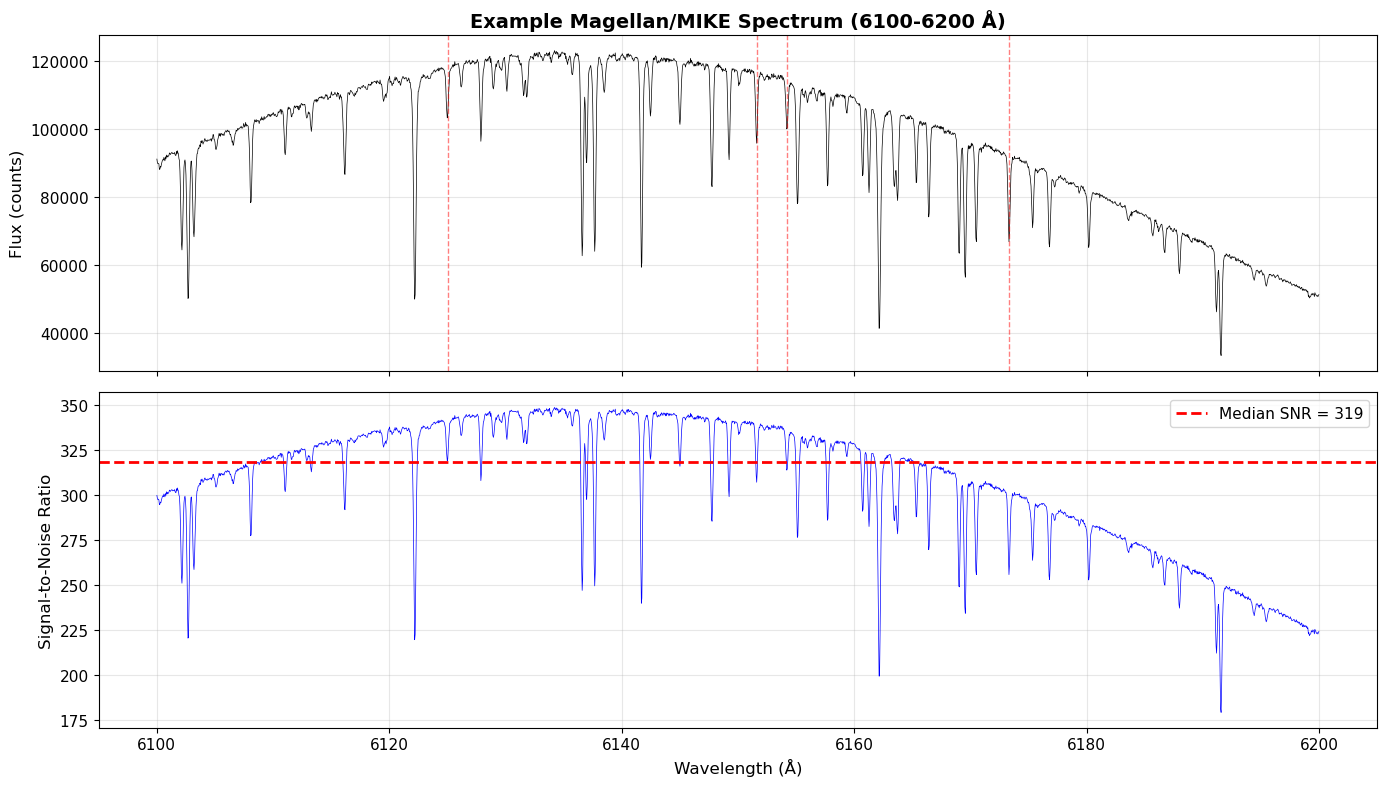


Red dashed lines mark example absorption features that will be measured.


In [3]:
# Visualize the spectrum
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Top panel: Flux spectrum
ax1 = axes[0]
ax1.plot(spectrum['wavelength'], spectrum['flux'], 'k-', lw=0.5)
ax1.set_ylabel('Flux (counts)', fontsize=12)
ax1.set_title('Example Magellan/MIKE Spectrum (6100-6200 Å)', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)

# Mark some absorption lines
lines_to_mark = [6125.03, 6151.62, 6154.23, 6173.34]
for wave in lines_to_mark:
    ax1.axvline(wave, color='red', ls='--', alpha=0.5, lw=1)

# Bottom panel: SNR
ax2 = axes[1]
ax2.plot(spectrum['wavelength'], spectrum['snr'], 'b-', lw=0.5)
ax2.axhline(spectrum['snr'].median(), color='red', ls='--', lw=2, 
            label=f'Median SNR = {spectrum["snr"].median():.0f}')
ax2.set_xlabel('Wavelength (Å)', fontsize=12)
ax2.set_ylabel('Signal-to-Noise Ratio', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nRed dashed lines mark example absorption features that will be measured.")


## 2.2 Loading the Line List

The line list specifies which spectral lines to measure. Each line is identified by its rest wavelength. The example line list contains 14 lines in the 6100-6200 Å range, which typically include transitions from elements commonly used in stellar abundance analysis:

- **Fe I** (Iron): The most abundant metal, used for metallicity ([Fe/H]) determination
- **Si I** (Silicon): An alpha-element tracing core-collapse supernova enrichment
- **Na I** (Sodium): Traces nucleosynthesis and stellar populations
- **Ba II** (Barium): A neutron-capture element from the s-process

Note: The line list only requires wavelengths—Egent measures the EW regardless of species identification.


In [4]:
# Load and display the line list
linelist = pd.read_csv('example/linelist.csv')

print("LINE LIST FILE FORMAT")
print("=" * 50)
print(linelist.to_string(index=False))
print(f"\nTotal: {len(linelist)} lines to measure")


LINE LIST FILE FORMAT
 wavelength
    6125.03
    6127.91
    6141.71
    6142.49
    6145.02
    6151.62
    6154.23
    6157.72
    6160.75
    6170.51
    6173.34
    6180.20
    6187.99

Total: 13 lines to measure


---

# Part 3: The Physics of Voigt Profile Fitting

## 3.1 Line Broadening Mechanisms

Spectral absorption lines are not infinitely narrow—they are broadened by several physical mechanisms:

1. **Natural broadening** (Lorentzian): From the finite lifetime of excited atomic states, giving a Lorentzian profile with characteristic width γ

2. **Thermal broadening** (Gaussian): From the Maxwell-Boltzmann velocity distribution of absorbing atoms, giving a Gaussian profile with width σ proportional to √(T/m)

3. **Pressure/collisional broadening** (Lorentzian): From interactions with other atoms in the stellar atmosphere

4. **Instrumental broadening** (approximately Gaussian): From the spectrograph's finite resolving power

## 3.2 The Voigt Profile

The **Voigt profile** is the convolution of Gaussian and Lorentzian profiles, capturing both thermal and pressure broadening:

$$V(\lambda; \lambda_0, A, \sigma, \gamma) = A \cdot \frac{\text{Re}[w(z)]}{\sigma\sqrt{2\pi}}$$

where $w(z)$ is the Faddeeva function and $z = \frac{(\lambda - \lambda_0) + i\gamma}{\sigma\sqrt{2}}$.

The four Voigt parameters are:
- **λ₀**: Line center wavelength
- **A**: Amplitude (absorption depth)
- **σ**: Gaussian width (thermal + instrumental)
- **γ**: Lorentzian width (natural + pressure)

The equivalent width is then computed by integrating the Voigt profile.


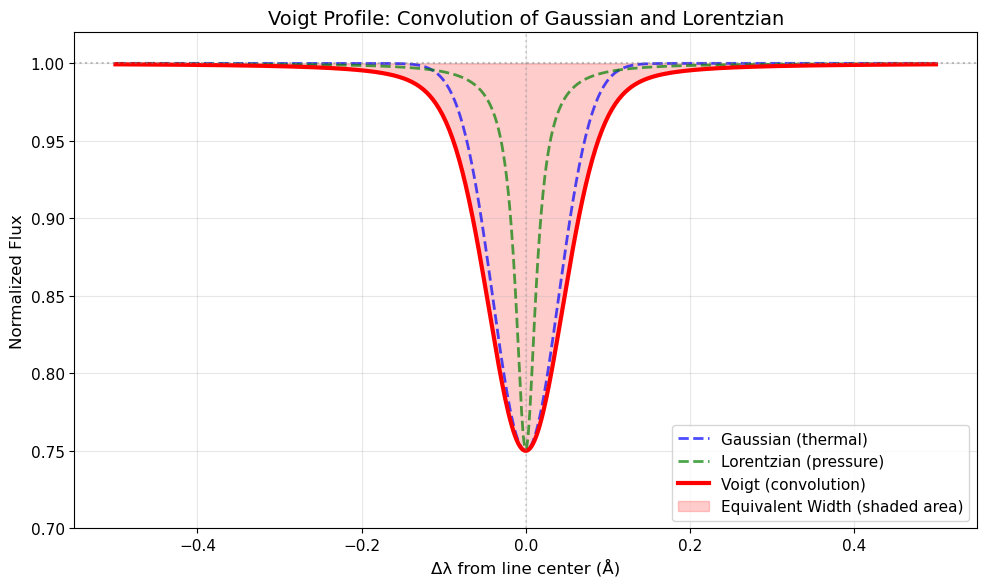

Voigt parameters: σ = 0.04 Å, γ = 0.015 Å
FWHM ≈ 0.094 Å
Equivalent Width = 32.4 mÅ


In [5]:
# Visualize Voigt profile components
from scipy.special import voigt_profile

# Create wavelength grid centered on line
wavelength = np.linspace(-0.5, 0.5, 500)

# Typical parameters for a stellar absorption line
sigma = 0.04   # Gaussian width (Å) - thermal + instrumental
gamma = 0.015  # Lorentzian width (Å) - pressure broadening
amplitude = 0.25  # Absorption depth (25% of continuum)

# Calculate profiles
voigt = voigt_profile(wavelength, sigma, gamma)
voigt_norm = voigt / voigt.max() * amplitude

gaussian = amplitude * np.exp(-wavelength**2 / (2 * sigma**2))
lorentzian = amplitude * gamma**2 / (wavelength**2 + gamma**2)

# Plot comparison
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(wavelength, 1 - gaussian, 'b--', lw=2, alpha=0.7, label='Gaussian (thermal)')
ax.plot(wavelength, 1 - lorentzian, 'g--', lw=2, alpha=0.7, label='Lorentzian (pressure)')
ax.plot(wavelength, 1 - voigt_norm, 'r-', lw=3, label='Voigt (convolution)')
ax.axhline(1, color='gray', ls=':', alpha=0.5)
ax.axvline(0, color='gray', ls=':', alpha=0.3)

ax.fill_between(wavelength, 1, 1 - voigt_norm, alpha=0.2, color='red', 
                label='Equivalent Width (shaded area)')

ax.set_xlabel('Δλ from line center (Å)', fontsize=12)
ax.set_ylabel('Normalized Flux', fontsize=12)
ax.set_title('Voigt Profile: Convolution of Gaussian and Lorentzian', fontsize=14)
ax.legend(loc='lower right', fontsize=11)
ax.set_ylim(0.7, 1.02)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate and display EW
from scipy.integrate import trapezoid
ew = trapezoid(voigt_norm, wavelength) * 1000  # Convert to mÅ
print(f"Voigt parameters: σ = {sigma} Å, γ = {gamma} Å")
print(f"FWHM ≈ {2.355 * sigma:.3f} Å")
print(f"Equivalent Width = {ew:.1f} mÅ")


---

# Part 4: Running the EW Measurement Pipeline

Now we'll run Egent on all lines in the line list. The pipeline will:

1. **For each line**: Extract a spectral window, estimate the continuum, and fit a multi-Voigt model
2. **Quality assessment**: Compute RMS, χ², and check for residual patterns
3. **LLM review**: If quality metrics indicate problems (RMS > 2.5σ, χ² > 15, etc.), the LLM inspects the diagnostic plot and autonomously decides how to improve the fit:
   - Adjust the window size to capture more continuum
   - Add blend components for unresolved neighboring lines
   - Change continuum fitting method (polynomial vs iterative)
   - Flag the line as unreliable if no good fit is possible
4. **Output**: Save results JSON and diagnostic plots

### Understanding the Parameters

- **`n_workers`**: Number of parallel threads for processing lines simultaneously. Higher values = faster, but may hit API rate limits. Start with 3-5, increase if no rate limit errors.
- **`clean_plots`**: When `True`, removes temporary LLM working plots after completion, keeping only the final diagnostic plots in `fits/`.

### Understanding the Output Messages

During processing, you'll see messages like:
- `✓` = Direct fit accepted (no LLM needed, fast)
- `🔄` = LLM reviewed and improved/confirmed the fit
- `🚩` = Line flagged as unreliable (e.g., high RMS even after LLM attempts)

When LLM is invoked, you'll see explanations like:
- `RMS>2.5σ, LLM will try to improve continuum/blends` - residuals are too large
- `≥10 lines detected, LLM will check for missed blends` - crowded region
- `residual_slope` - continuum may be tilted, LLM will adjust


In [ ]:
# Run the EW measurement pipeline
from run_ew import run_ew_analysis

# Define output directory
output_dir = './tutorial_output'

# Determine number of workers based on backend
# - OpenAI: Can use parallel workers (3-5 recommended)
# - Local: Must use 1 worker (no parallelism with local model)
backend = os.environ.get('EGENT_BACKEND', 'openai')
if backend == 'local':
    n_workers = 1
    print("⚠️  Using LOCAL backend (Qwen3-VL-8B)")
    print("   • Single worker (no parallelism)")
    print("   • Expect ~60-120 seconds per line with LLM review")
    print("   • Results NOT benchmarked - use for offline testing only")
    print()
else:
    n_workers = 3
    print("🚀 Using OpenAI backend (GPT-5-mini)")
    print(f"   • {n_workers} parallel workers")
    print()

# Run the pipeline
# - n_workers: number of parallel threads (adjust based on API rate limits)
# - clean_plots: remove temporary LLM working plots after completion
results = run_ew_analysis(
    spectrum_file='example/spectrum.csv',
    linelist_file='example/linelist.csv',
    n_workers=n_workers,
    output_dir=output_dir,
    clean_plots=True  # Clean up temp plots when done
)


⚠️  Using LOCAL backend (Qwen3-VL-8B)
   • Single worker (no parallelism)
   • Expect ~60-120 seconds per line with LLM review
   • Results NOT benchmarked - use for offline testing only

Spectrum: example/spectrum.csv
  2318 points, 6100.0-6200.0 Å
  Median SNR: 319

Line list: example/linelist.csv
  13 lines to measure

EGENT EW ANALYSIS: 13 lines
Model: lmstudio-community/Qwen3-VL-8B-Instruct-MLX-4bit | Workers: 1
Started: 2025-12-01 20:56:10

    [1/13] 6125.03Å: Direct=30.0mÅ → LLM review (RMS>2.5σ, LLM will try to improve continuum/blends)
🔄 Loading local model: lmstudio-community/Qwen3-VL-8B-Instruct-MLX-4bit
   (First run will download ~4GB from HuggingFace)


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

✅ Model loaded successfully!


---

# Part 5: Analyzing the Results

## 5.1 Results Summary

Let's examine the measurement results. Each line has:
- **measured_ew**: The equivalent width in milli-Angstroms (mÅ)
- **ew_err**: Uncertainty from the covariance matrix
- **fit_quality**: 'good', 'acceptable', or 'poor'
- **used_llm**: Whether LLM intervention was needed
- **flagged**: Whether the line was flagged as unreliable


In [ ]:
# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results)

# Display summary statistics
print("=" * 70)
print("RESULTS SUMMARY")
print("=" * 70)

# Count by category
n_total = len(results_df)
n_success = len(results_df[results_df['success'] == True])
n_flagged = len(results_df[results_df['flagged'] == True])
n_direct = len(results_df[(results_df['used_llm'] == False) & (results_df['success'] == True)])
n_llm = len(results_df[(results_df['used_llm'] == True) & (results_df['flagged'] != True)])

print(f"\nTotal lines measured: {n_total}")
print(f"  ✓ Successful: {n_success}")
print(f"  🚩 Flagged: {n_flagged}")
print(f"\nMethod breakdown:")
print(f"  Direct fits (no LLM): {n_direct}")
print(f"  LLM-refined: {n_llm}")


RESULTS SUMMARY

Total lines measured: 14
  ✓ Successful: 14
  🚩 Flagged: 1

Method breakdown:
  Direct fits (no LLM): 5
  LLM-refined: 8


In [ ]:
# Display all measurements in a nice table
print("\n" + "=" * 70)
print("INDIVIDUAL MEASUREMENTS")
print("=" * 70)
print(f"{'Wavelength':>10} {'EW (mÅ)':>12} {'Error':>8} {'Quality':>12} {'Method':>8} {'Status':>10}")
print("-" * 70)

for _, row in results_df.iterrows():
    wave = row['wavelength']
    
    if row.get('flagged'):
        status = "FLAGGED"
        ew_str = "---"
        err_str = "---"
        quality = row.get('flag_reason', 'unknown')[:12]
        method = "---"
    elif row.get('measured_ew'):
        status = "OK"
        ew_str = f"{row['measured_ew']:.1f}"
        err_str = f"±{row.get('ew_err', 0):.1f}"
        quality = row.get('fit_quality', 'N/A')
        method = "LLM" if row.get('used_llm') else "Direct"
    else:
        status = "FAILED"
        ew_str = "---"
        err_str = "---"
        quality = "---"
        method = "---"
    
    print(f"{wave:>10.2f} {ew_str:>12} {err_str:>8} {quality:>12} {method:>8} {status:>10}")



INDIVIDUAL MEASUREMENTS
Wavelength      EW (mÅ)    Error      Quality   Method     Status
----------------------------------------------------------------------
   6127.91         45.3     ±2.1   acceptable   Direct         OK
   6125.03         30.0     ±1.6         good      LLM         OK
   6145.02         36.8     ±1.8         good   Direct         OK
   6142.49         32.6     ±1.8         good      LLM         OK
   6151.62         35.7     ±1.5   acceptable      LLM         OK
   6154.23         27.9     ±1.7   acceptable      LLM         OK
   6141.71        124.1     ±1.8   acceptable      LLM         OK
   6165.36         34.8     ±1.5         good      LLM         OK
   6170.51         76.1     ±2.5         good   Direct         OK
   6173.34         62.2     ±2.1         good   Direct         OK
   6157.72          ---      --- auto_high_rm      ---    FLAGGED
   6187.99         37.9     ±2.0         good   Direct         OK
   6160.75         53.2     ±3.7         good 

## 5.2 Reading the Output JSON File

Egent saves complete results to a JSON file including all metadata, Voigt parameters, and LLM conversation logs. This provides full provenance for every measurement—you can exactly reconstruct any fit from the saved parameters.


In [ ]:
# Find and load the results JSON file
results_files = sorted(Path(output_dir).glob('results_*.json'))

if results_files:
    json_file = results_files[-1]  # Most recent
    print(f"Loading: {json_file}")
    
    with open(json_file) as f:
        full_results = json.load(f)
    
    # Display structure
    print("\n" + "=" * 70)
    print("JSON FILE STRUCTURE")
    print("=" * 70)
    print(f"\nTop-level keys: {list(full_results.keys())}")
    
    print(f"\n📋 metadata:")
    for k, v in full_results['metadata'].items():
        print(f"   {k}: {v}")
    
    print(f"\n📊 summary:")
    for k, v in full_results['summary'].items():
        print(f"   {k}: {v}")
    
    print(f"\n📈 results: {len(full_results['results'])} line entries")
else:
    print("No results file found. Run the pipeline first.")


Loading: tutorial_output/results_20251201_204733.json

JSON FILE STRUCTURE

Top-level keys: ['metadata', 'summary', 'results']

📋 metadata:
   spectrum_file: example/spectrum.csv
   linelist_file: example/linelist.csv
   timestamp: 20251201_204733
   n_lines: 14
   n_workers: 3
   model: gpt-5-mini

📊 summary:
   direct: 5
   llm: 8
   flagged: 1
   timeout: 0
   failed: 0

📈 results: 14 line entries


In [ ]:
# Examine one result in detail - shows the full data structure
print("=" * 70)
print("DETAILED RESULT EXAMPLE")
print("=" * 70)

# Find a successful measurement
for r in full_results['results']:
    if r.get('success') and r.get('measured_ew') and not r.get('flagged'):
        print(f"\nLine: {r['wavelength']:.2f} Å")
        print(f"\n🎯 MEASUREMENT:")
        print(f"   EW: {r['measured_ew']:.2f} ± {r.get('ew_err', 0):.2f} mÅ")
        print(f"   Fit quality: {r.get('fit_quality', 'N/A')}")
        print(f"   Method: {'LLM-refined' if r.get('used_llm') else 'Direct fit'}")
        
        # Voigt parameters - these allow exact reconstruction
        if r.get('direct_voigt_params') and r['direct_voigt_params'].get('target'):
            vp = r['direct_voigt_params']['target']
            print(f"\n📐 VOIGT PARAMETERS (for reconstruction):")
            print(f"   Center (λ₀): {vp['center']:.4f} Å")
            print(f"   Amplitude (A): {vp['amplitude']:.4f}")
            print(f"   Gaussian σ: {vp['sigma']:.5f} Å")
            print(f"   Lorentzian γ: {vp['gamma']:.5f} Å")
            print(f"   FWHM: {vp.get('fwhm', 0):.4f} Å")
        
        # Continuum info
        if r.get('continuum_info'):
            ci = r['continuum_info']
            print(f"\n📏 CONTINUUM:")
            print(f"   Method: {ci.get('method', 'N/A')}")
            if ci.get('fitted_continuum_coeffs'):
                print(f"   Polynomial coefficients: {ci['fitted_continuum_coeffs']}")
        
        # LLM reasoning (if used)
        if r.get('used_llm') and r.get('iterations'):
            print(f"\n🤖 LLM REASONING:")
            for i, it in enumerate(r['iterations'][:2]):  # Show first 2 iterations
                print(f"   Iteration {i+1}: {it.get('thought', 'N/A')[:80]}...")
        
        break


DETAILED RESULT EXAMPLE

Line: 6127.91 Å

🎯 MEASUREMENT:
   EW: 45.31 ± 2.05 mÅ
   Fit quality: acceptable
   Method: Direct fit

📐 VOIGT PARAMETERS (for reconstruction):
   Center (λ₀): 6127.9048 Å
   Amplitude (A): 0.1943
   Gaussian σ: 0.07657 Å
   Lorentzian γ: 0.02314 Å
   FWHM: 0.1803 Å

📏 CONTINUUM:
   Method: iterative_linear
   Polynomial coefficients: [0.9995785060279745, 0.00045642359302265]


---

# Part 6: Viewing Diagnostic Plots

Egent generates diagnostic plots for every measured line, organized into subdirectories based on how the measurement was obtained:

### Output Directory Structure

- **`fits/direct/`**: The initial multi-Voigt fit was already good (RMS < 2.5σ, no residual patterns). These lines were measured quickly without needing LLM review. This is the ideal case—fast and reliable.

- **`fits/llm/`**: The initial fit had quality issues (high RMS, elevated χ², tilted residuals, crowded region, etc.), so the LLM visually inspected the plot and made improvements. The LLM may have adjusted the window size, added blend components, or changed the continuum method. The final measurement passed quality checks.

- **`fits/flagged/`**: The LLM reviewed the fit but determined it was unreliable—perhaps due to severe blending, cosmic rays, or other issues that couldn't be resolved. These measurements should be treated with caution or excluded.

- **`fits/error/`**: Something went wrong during processing (API timeout, etc.). These lines may need to be re-run.

Each plot shows the normalized spectrum, multi-Voigt fit, and residuals with quality metrics.


In [ ]:
# List available diagnostic plots
fits_dir = Path(output_dir) / 'fits'

if fits_dir.exists():
    print("AVAILABLE DIAGNOSTIC PLOTS")
    print("=" * 70)
    
    for subdir in ['direct', 'llm', 'flagged', 'error']:
        subpath = fits_dir / subdir
        if subpath.exists():
            plots = sorted(subpath.glob('*.png'))
            print(f"\n📁 {subdir}/ ({len(plots)} plots)")
            for p in plots[:5]:  # Show first 5
                print(f"   • {p.name}")
            if len(plots) > 5:
                print(f"   ... and {len(plots) - 5} more")
else:
    print("No plots directory found. Run the pipeline first.")


AVAILABLE DIAGNOSTIC PLOTS

📁 direct/ (5 plots)
   • 6127.91.png
   • 6145.02.png
   • 6170.51.png
   • 6173.34.png
   • 6187.99.png

📁 llm/ (8 plots)
   • 6125.03.png
   • 6141.71.png
   • 6142.49.png
   • 6151.62.png
   • 6154.23.png
   ... and 3 more

📁 flagged/ (1 plots)
   • 6157.72.png


EXAMPLE DIAGNOSTIC PLOTS

📊 DIRECT FIT EXAMPLE: 6127.91.png


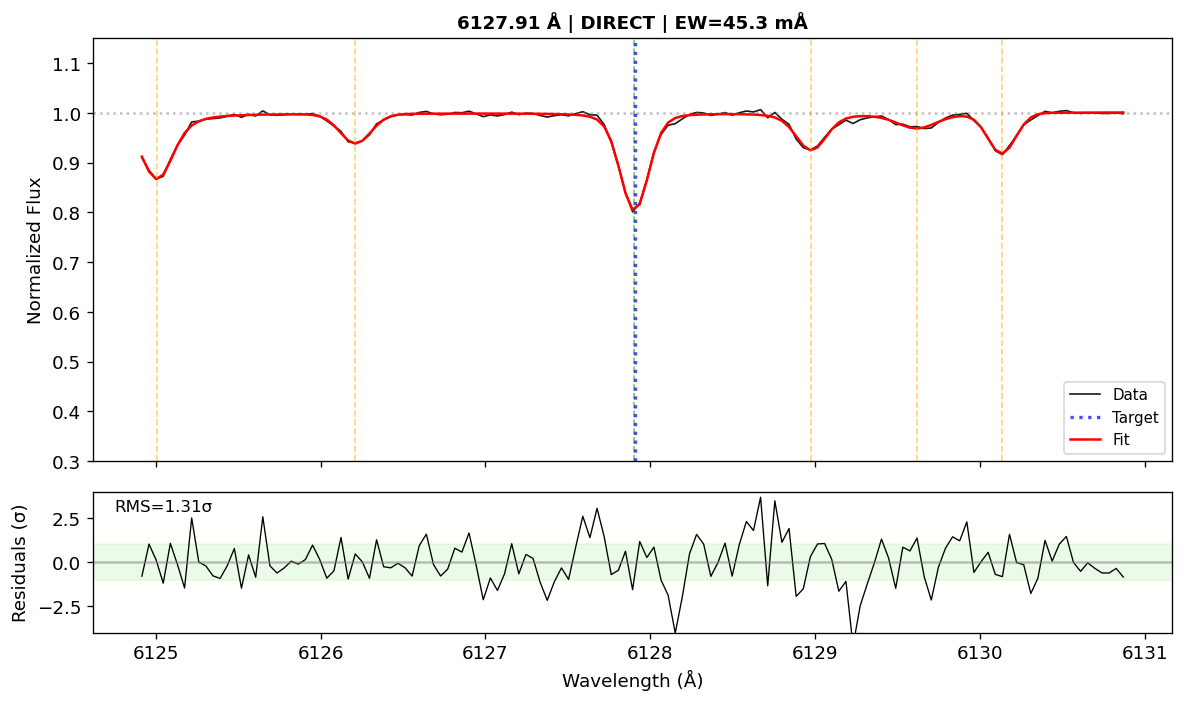


📊 LLM FIT EXAMPLE: 6125.03.png


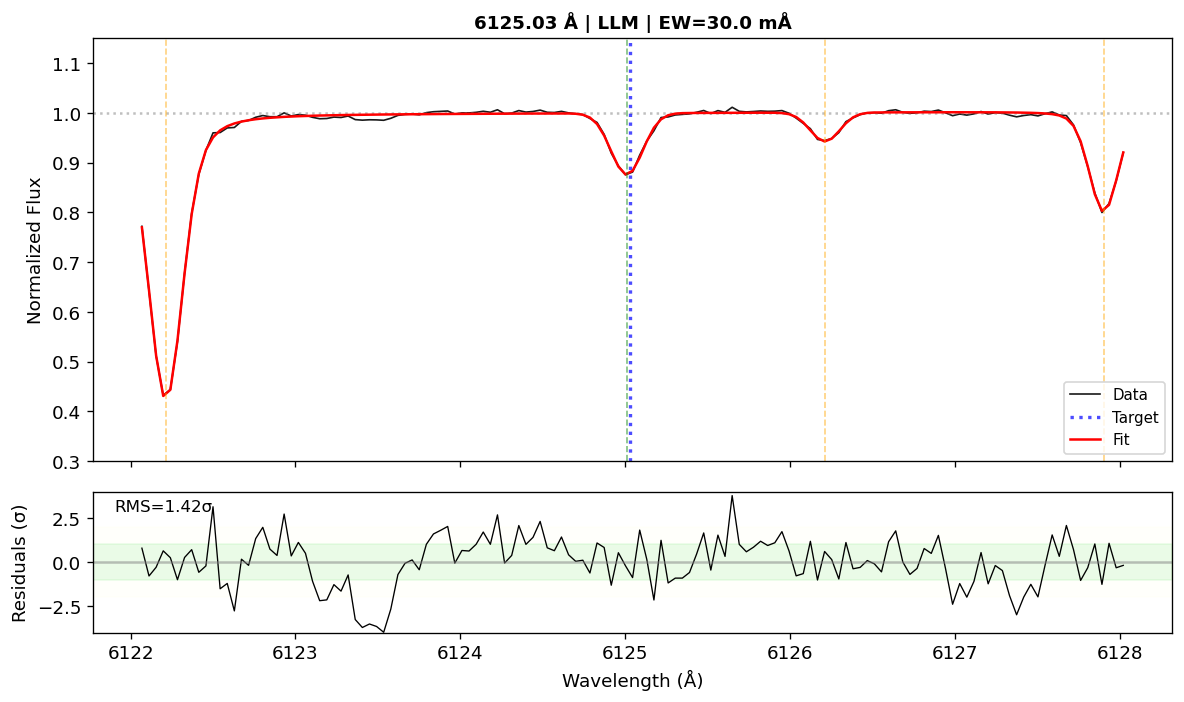


📊 FLAGGED FIT EXAMPLE: 6157.72.png


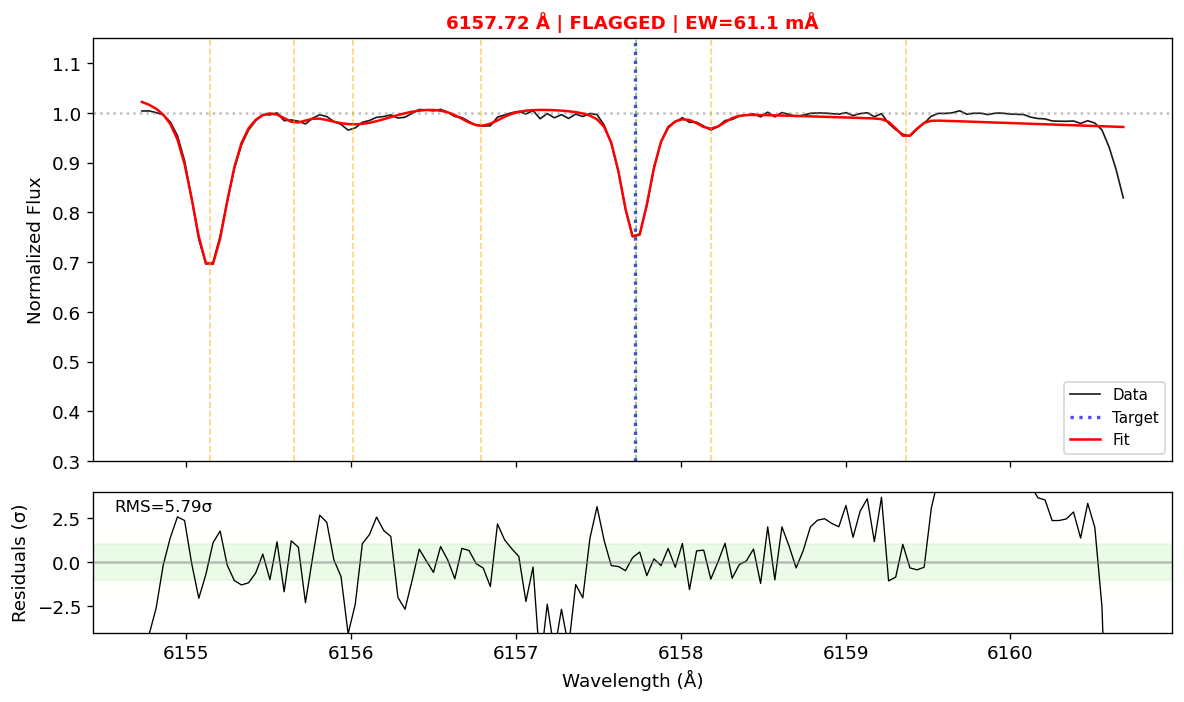

In [ ]:
# Display example plots from each category
print("EXAMPLE DIAGNOSTIC PLOTS")
print("=" * 70)

for subdir in ['direct', 'llm', 'flagged']:
    subpath = fits_dir / subdir
    if subpath.exists():
        plots = sorted(subpath.glob('*.png'))
        if plots:
            print(f"\n{'='*70}")
            print(f"📊 {subdir.upper()} FIT EXAMPLE: {plots[0].name}")
            print(f"{'='*70}")
            display(Image(filename=str(plots[0]), width=700))


## 6.1 Understanding the Diagnostic Plots

Each diagnostic plot contains two panels:

**Top Panel - Normalized Spectrum:**
- **Black line**: Observed data, normalized by the fitted continuum
- **Red line**: Multi-Voigt model fit
- **Blue dashed line**: Target wavelength (the line you're measuring)
- **Green/Orange dashed lines**: Centers of fitted Voigt components (green = target, orange = blends)
- **Gray horizontal line**: Continuum level (1.0)

**Bottom Panel - Residuals:**
- Shows (data - model) normalized by the flux uncertainty
- **Green band**: ±1σ range (68% of points should fall here for a good fit)
- **Yellow band**: ±2σ range (95% of points should fall here)
- **RMS value**: Root-mean-square of normalized residuals (should be ~1.0 for a good fit)

### Quality Interpretation
- **RMS < 1.5σ**: Excellent fit
- **RMS 1.5-2.0σ**: Good fit  
- **RMS 2.0-2.5σ**: Marginal (LLM reviews these)
- **RMS > 2.5σ**: Poor fit (usually flagged)


---

# Summary and Next Steps

## What We Covered

In this tutorial, you learned:

1. **Setup**: How to obtain an OpenAI API key and configure Egent
2. **Input data**: The simple CSV format for spectra and line lists
3. **Physics**: How Voigt profiles model spectral absorption lines
4. **Pipeline**: How Egent combines direct fitting with LLM visual inspection
5. **Output**: How to read the results JSON and interpret diagnostic plots

## Using Your Own Data

To analyze your own spectra:

1. **Prepare your spectrum**: Create a CSV with columns `wavelength`, `flux`, `flux_error`
   - Wavelengths must be in the stellar rest frame (apply barycentric + RV corrections first)
   - Any flux units work (Egent normalizes internally)

2. **Create your line list**: CSV with column `wavelength` containing rest wavelengths to measure

3. **Run the analysis**:
```python
results = run_ew_analysis(
    spectrum_file='your_spectrum.csv',
    linelist_file='your_linelist.csv',
    n_workers=5,
    output_dir='./output'
)
```

## Tips for Best Results

- **High SNR**: Egent works best with SNR > 50 per pixel
- **Clean continuum**: Avoid regions with strong molecular bands or emission
- **Isolated lines**: Heavily blended lines may require manual continuum regions
- **Rest frame**: Always ensure spectra are in the stellar rest frame

## Troubleshooting

| Issue | Solution |
|-------|----------|
| API rate limit errors | Reduce `n_workers` (try 2-3) and wait a few minutes |
| Many flagged lines | Check wavelength calibration—spectra must be in rest frame |
| Poor fits on many lines | May indicate SNR issues or incorrect flux_error values |
| Lines not found | Ensure line wavelengths fall within spectrum coverage |
| Timeout errors | The LLM took too long; result may still be usable from direct fit |

**Note**: The LLM autonomously decides how to improve fits (continuum method, window size, blend components). You don't need to configure these manually—that's the whole point of the agent!

## Citation

If you use Egent in your research, please cite:

```
Ting et al. (2025), "Egent: An Autonomous Agent for Equivalent Width Measurement"
```
